In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
from tqdm import tqdm, trange
import time
import random

from glob import glob
import os
from PIL import Image


from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow import keras
from keras import layers
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory # data split
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping


In [6]:
glob("*")

['dementia_EDA_analysis.ipynb',
 'Alzheimer_MRI_Preprocessed_Dataset_지민님.ipynb',
 'oasis2.xml',
 '캐글_폐렴_필사.ipynb',
 'pretrain_data.zip',
 'pretrain_data',
 'pretrain_dementia_ver2.ipynb',
 'oasis_longitudinal.csv',
 'pretrain_dementia_data.zip',
 'pretrain_dementia_data',
 'oasis_2_analysis.ipynb',
 'model.png',
 'chest_xray.zip',
 'mri_hippocampus_segmentation.ipynb',
 'chest_xray',
 'oasis1.xml',
 'output',
 'pretrain_dementia_ver1.ipynb',
 'preview',
 '__MACOSX']

In [7]:
root_dir = "pretrain_dementia_data/"
os.listdir(root_dir)[:-1]

['moderate', 'mild', 'non']


# 리스트로 변환

In [8]:
# 경로, label, mri_id 리스트로 저장

path_list = [] # 경로
label_list = [] # 레이블= Y
mri_id_list = [] # 이미지 이름

# root_dir 경로 안에 있는 폴더마다 img가져오고, 폴더명을 y값으로 저장
for folder_name in os.listdir(root_dir)[:-1]:
    for img in os.listdir(root_dir + folder_name):
        path_list.append(f'{root_dir + folder_name}/{img}')  # img 가져오기
        label_list.append(folder_name)  # folder_name을 y값으로 저장
        mri_id_list.append(img)
        
mri_id_list = [ i.split(".")[0] for i in mri_id_list]
mri_id_list

['mild_48',
 'mild_509',
 'mild_752',
 'mild_623',
 'mild_301',
 'mild_698',
 'mild_53',
 'mild_721',
 'mild_161',
 'mild_4',
 'mild_446',
 'mild_551',
 'mild_166',
 'mild_213',
 'mild_228',
 'mild_771',
 'mild_430',
 'mild_595',
 'mild_181',
 'mild_423',
 'moderate_52',
 'mild_419',
 'mild_46',
 'mild_271',
 'moderate_36',
 'mild_894',
 'mild_314',
 'mild_510',
 'mild_341',
 'mild_803',
 'mild_277',
 'mild_422',
 'mild_236',
 'mild_248',
 'mild_880',
 'mild_163',
 'mild_128',
 'mild_686',
 'mild_25',
 'mild_410',
 'moderate_45',
 'mild_347',
 'mild_617',
 'mild_777',
 'mild_68',
 'moderate_26',
 'mild_283',
 'mild_266',
 'mild_624',
 'mild_780',
 'mild_50',
 'mild_64',
 'mild_568',
 'mild_135',
 'mild_483',
 'mild_481',
 'mild_892',
 'mild_659',
 'mild_406',
 'mild_454',
 'mild_495',
 'mild_92',
 'mild_407',
 'mild_346',
 'mild_536',
 'mild_582',
 'mild_318',
 'mild_736',
 'mild_590',
 'mild_434',
 'mild_654',
 'mild_776',
 'mild_120',
 'mild_635',
 'mild_550',
 'mild_796',
 'mild_757

In [9]:
# 이미지 출력 함수
def open_img(idx) :
    return Image.open(path_list[idx])


# 이미지 출력을 담은 리스트
open_img_list = [Image.open(i) for i in path_list]


In [ ]:
# group_list에 그룹별로 잘 나뉘었는지 확인
print(pd.Series(label_list).value_counts())
print(sum(pd.Series(label_list).value_counts()))
# img_list에 담긴 이미지 파일 확인
fig, axes = plt.subplots(1, 8, figsize=(20, 5))
for i in range(len(axes)):
    num = np.random.randint(0, pd.Series(label_list).value_counts().sum())
    axes[i].imshow(open_img_list[num])
    axes[i].set_title(label_list[num])

# 데이터프레임 생성

In [8]:
df_label = [mri_id_list,path_list,label_list]
df_label = pd.DataFrame(df_label).T
df_label.columns = ["mri_id", "path", "demented"]

df_label

,mri_id,path,demented
0,mild_48,pretrain_dementia_data/moderate/mild_48.jpg,moderate
1,mild_509,pretrain_dementia_data/moderate/mild_509.jpg,moderate
2,mild_752,pretrain_dementia_data/moderate/mild_752.jpg,moderate
3,mild_623,pretrain_dementia_data/moderate/mild_623.jpg,moderate
4,mild_301,pretrain_dementia_data/moderate/mild_301.jpg,moderate
...,...,...,...
6413,non_1314,pretrain_dementia_data/non/non_1314.jpg,non
6414,non_1256,pretrain_dementia_data/non/non_1256.jpg,non
6415,non_1971,pretrain_dementia_data/non/non_1971.jpg,non
6416,non_1574,pretrain_dementia_data/non/non_1574.jpg,non


# 데이터 확인

In [9]:
df_label["demented"].value_counts()

non         3206
mild        2246
moderate     966
Name: demented, dtype: int64

<AxesSubplot:>

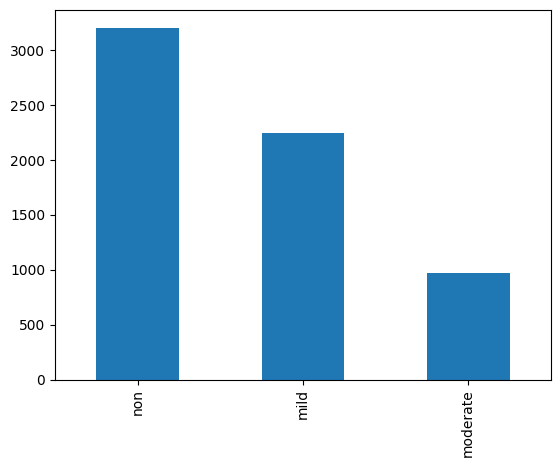

In [10]:
df_label["demented"].value_counts().plot.bar()

# 이미지 전처리
- 데이터양이 충분하여 데이터 증강은 불필요해보인다
- grayscaling을 진행 할 것이다

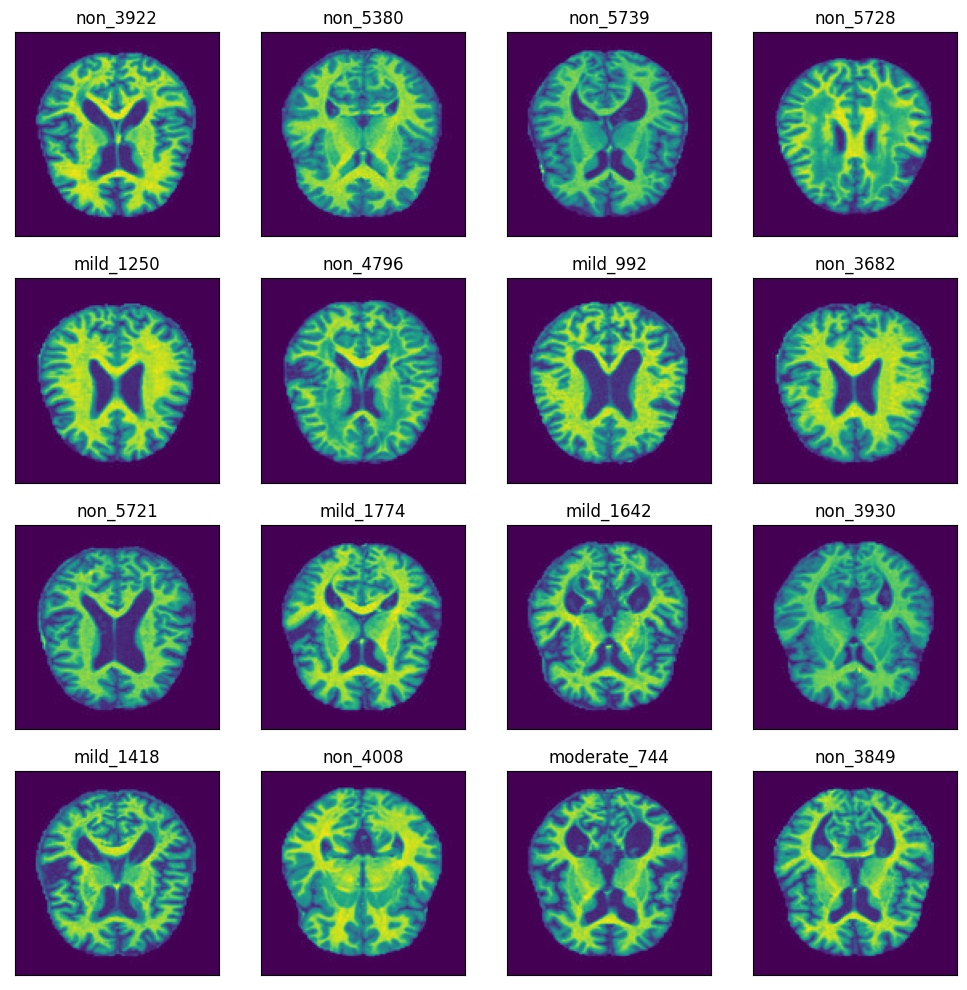

In [11]:
# 랜덤으로 16개 뽑아서 보기
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(df_label), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_label.path[random_index[i]]))
    ax.set_title(f"{df_label.demented[random_index[i]]}_{random_index[i]}")
plt.tight_layout()
plt.show()

# Data Augmentation

In [10]:
!pip install split-folders

ValueError: filedescriptor out of range in select()

In [ ]:
# demo_datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     rescale=1./255,
#     shear_range=0.05,
#     brightness_range=[0.1, 1.5],
#     horizontal_flip=True,
#     vertical_flip=True
# )

# train_generator = demo_datagen.flow_from_directory(
#     directory='data/',
#     target_size=(128, 128),
#     batch_size=32,
#     class_mode='categorical',
#     subset='training'
# )

# val_generator = demo_datagen.flow_from_directory(
#     directory='data/',
#     target_size=(128, 128),
#     batch_size=32,
#     class_mode='categorical',
#     subset='validation'
# )

# test_generator = demo_datagen.flow_from_directory(
#     directory='data/',
#     target_size=(128, 128),
#     batch_size=32,
#     class_mode='categorical',
#     subset='test'
# )

In [13]:
# 데이터 증강!!!!

# 데이터가 있는 루트 디렉토리 경로
# root_dir = 'pretrain_dementia_data/'

# mild, non, moderate 디렉토리에 대한 경로
mild_dir = os.path.join(root_dir, 'mild')
non_dir = os.path.join(root_dir, 'non')
moderate_dir = os.path.join(root_dir, 'moderate')

# ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

# mild, non, moderate 디렉토리의 이미지들을 증강시키고 저장
for dirname in tqdm([mild_dir, non_dir, moderate_dir]):
    # 디렉토리 내의 파일 리스트 가져오기
    fnames = [os.path.join(dirname, fname) for fname in os.listdir(dirname)]

    for fname in tqdm(fnames):
        # 이미지 로드
        img = load_img(fname)

        # 이미지를 array로 변환
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # flow() 메소드를 이용하여 이미지 증강
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=dirname, save_prefix='aug_', save_format='jpg', seed=42):
            i += 1
            if i > 10: # 증강한 이미지를 5장까지만 생성하도록 설정
                break
                


  0% 0/3 [00:00<?, ?it/s]
  0% 0/2246 [00:00<?, ?it/s]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  4.32it/s]

2it [00:00,  3.73it/s]           

3it [00:00,  3.04it/s]

4it [00:01,  3.30it/s]

5it [00:01,  2.97it/s]

  0% 1/2246 [00:01<1:03:14,  1.69s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  2.24it/s]

2it [00:00,  2.66it/s]           

3it [00:01,  3.04it/s]

4it [00:01,  3.12it/s]

5it [00:01,  2.88it/s]

  0% 2/2246 [00:03<1:04:15,  1.72s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  2.81it/s]

2it [00:00,  2.91it/s]           

3it [00:00,  3.25it/s]

4it [00:01,  3.45it/s]

5it [00:01,  2.66it/s]

  0% 3/2246 [00:05<1:07:04,  1.79s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  2.10it/s]

2it [00:01,  1.06it/s]           

3it [00:02,  1.54it/s]

4it [00:02,  1.86it/s]

5it [00:02,  1.75it/s]

  0% 4/2246 [00:08<1:22:56,  2.22s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  2.86it/s]

3it [00:00,  5.03it/s]           

5it [00:01,

  3% 68/2246 [02:38<1:44:01,  2.87s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  1.42it/s]

2it [00:01,  1.98it/s]           

3it [00:01,  1.77it/s]

5it [00:02,  1.87it/s]

  3% 69/2246 [02:41<1:41:52,  2.81s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  5.86it/s]

2it [00:00,  2.21it/s]           

3it [00:01,  2.58it/s]

4it [00:01,  3.28it/s]

5it [00:02,  2.13it/s]

  3% 70/2246 [02:44<1:36:55,  2.67s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  1.51it/s]

2it [00:01,  1.95it/s]           

3it [00:01,  1.61it/s]

4it [00:01,  2.24it/s]

5it [00:03,  1.62it/s]

  3% 71/2246 [02:47<1:41:26,  2.80s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  1.89it/s]

2it [00:00,  2.12it/s]           

3it [00:01,  2.05it/s]

4it [00:01,  2.33it/s]

5it [00:02,  1.87it/s]

  3% 72/2246 [02:49<1:40:05,  2.76s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.03it/s]

2it [00:00,  2.54it/s]           

3it [00:01,  2.10it/s]

4it [00:01,  2.07it/s]

  7% 151/2246 [04:47<20:08,  1.73it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 18.31it/s]   

5it [00:00,  9.38it/s]

  7% 152/2246 [04:48<19:44,  1.77it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 12.83it/s]   

  7% 153/2246 [04:48<17:56,  1.94it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 11.84it/s]   

5it [00:00, 12.58it/s]

  7% 154/2246 [04:49<16:45,  2.08it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 12.82it/s]   

  7% 155/2246 [04:49<15:51,  2.20it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 13.45it/s]   

  7% 156/2246 [04:49<15:01,  2.32it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 19.67it/s]   

5it [00:00, 16.65it/s]

  7% 157/2246 [04:50<13:43,  2.54it/s]

  0% 0/1 [00:00<?, ?it/s]

3it [00:00, 11.93it/s]   

5it [00:00, 10.21it/s]

  7% 158/2246 [04:50<14:47,  2.35it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 19.36it/s]   

5it [00:00,  9.98it/s]

  7% 159/2246 [04:51<15:37,  2.23it/s]

  0% 0/1 [00:00<?, ?it/s]

3it [00:00, 16.86it/s]   

5it [00:00, 14.14it/s]

  7% 160/2

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  7.14it/s]

5it [00:00, 10.58it/s]           

 12% 266/2246 [05:47<16:30,  2.00it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 18.13it/s]   

 12% 267/2246 [05:47<14:19,  2.30it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 14.87it/s]   

 12% 268/2246 [05:47<13:23,  2.46it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 11.40it/s]   

5it [00:00, 10.41it/s]

 12% 269/2246 [05:48<14:10,  2.32it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 15.01it/s]   

 12% 270/2246 [05:48<13:15,  2.48it/s]

5it [00:00, 20.75it/s]   

 12% 271/2246 [05:48<11:42,  2.81it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 14.62it/s]   

 12% 272/2246 [05:49<11:38,  2.83it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 13.36it/s]   

5it [00:00, 10.23it/s]

 12% 273/2246 [05:49<13:01,  2.52it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 15.49it/s]   

 12% 274/2246 [05:50<12:21,  2.66it/s]

  0% 0/1 [00:00<?, ?it/s]

3it [00:00, 16.55it/s]   

5it [00:00, 11.22it/s]

 12% 275/224

4it [00:00,  5.98it/s]

5it [00:01,  4.26it/s]

 14% 325/2246 [06:16<23:09,  1.38it/s]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.66it/s]

2it [00:00,  3.71it/s]           

3it [00:00,  4.66it/s]

4it [00:01,  2.36it/s]

5it [00:01,  2.74it/s]

 15% 326/2246 [06:18<33:46,  1.06s/it]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 11.28it/s]   

 15% 327/2246 [06:18<27:55,  1.15it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 10.09it/s]   

4it [00:00,  5.38it/s]

5it [00:01,  4.71it/s]

 15% 328/2246 [06:19<29:47,  1.07it/s]

  0% 0/1 [00:00<?, ?it/s]

3it [00:00, 10.29it/s]   

5it [00:00,  5.38it/s]

 15% 329/2246 [06:20<29:48,  1.07it/s]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.00it/s]

3it [00:00,  7.18it/s]           

4it [00:00,  3.98it/s]

5it [00:01,  3.91it/s]

 15% 330/2246 [06:22<33:10,  1.04s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  4.84it/s]

2it [00:00,  5.96it/s]           

4it [00:00,  5.33it/s]

5it [00:01,  3.51it/s]

 15% 331/2246 [06:2

100% 1/1 [00:00<00:00,  5.02it/s]

3it [00:00,  9.97it/s]           

5it [00:00,  7.07it/s]

 19% 436/2246 [07:20<15:16,  1.97it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00,  8.50it/s]   

5it [00:00,  7.95it/s]

 19% 437/2246 [07:21<16:25,  1.84it/s]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  7.12it/s]

2it [00:00,  6.79it/s]           

3it [00:00,  6.51it/s]

5it [00:00,  6.80it/s]

 20% 438/2246 [07:21<18:12,  1.66it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 14.58it/s]   

 20% 439/2246 [07:22<15:52,  1.90it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 16.98it/s]   

5it [00:00,  9.84it/s]

 20% 440/2246 [07:22<15:44,  1.91it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 12.18it/s]   

5it [00:00, 11.56it/s]

 20% 441/2246 [07:23<14:59,  2.01it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 21.81it/s]           

 20% 442/2246 [07:23<12:36,  2.38it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 12.68it/s]   

5it [00:00,  9.34it/s]

 20% 443/2246 [07:23<13:42,  2.19it/s]

  0% 0/1 [00:

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 13.64it/s]           

 24% 546/2246 [08:20<14:01,  2.02it/s]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  6.81it/s]

2it [00:00,  6.62it/s]           

3it [00:00,  6.66it/s]

5it [00:00,  7.07it/s]

 24% 547/2246 [08:20<15:51,  1.79it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 19.17it/s]   

5it [00:00,  8.71it/s]

 24% 548/2246 [08:21<16:00,  1.77it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00,  9.74it/s]   

5it [00:00, 10.24it/s]

 24% 549/2246 [08:21<15:25,  1.83it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 13.97it/s]   

 24% 550/2246 [08:22<13:53,  2.04it/s]

  0% 0/1 [00:00<?, ?it/s]

3it [00:00, 16.28it/s]   

5it [00:00,  9.74it/s]

 25% 551/2246 [08:22<14:06,  2.00it/s]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  7.59it/s]

3it [00:00,  8.36it/s]           

5it [00:00,  7.95it/s]

 25% 552/2246 [08:23<15:13,  1.85it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 13.63it/s]   

 25% 553/2246 [08:23<13:48,  2.04it/s]

  0% 0/1 [

100% 1/1 [00:00<00:00,  6.33it/s]

5it [00:00, 11.36it/s]           

 29% 653/2246 [09:23<12:41,  2.09it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 19.24it/s]   

5it [00:00, 16.55it/s]

 29% 654/2246 [09:23<11:19,  2.34it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00,  6.67it/s]   

5it [00:00,  6.74it/s]

 29% 655/2246 [09:24<13:51,  1.91it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 12.32it/s]   

5it [00:00,  8.78it/s]

 29% 656/2246 [09:24<14:16,  1.86it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 12.65it/s]   

 29% 657/2246 [09:25<13:11,  2.01it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00,  8.42it/s]   

3it [00:00,  7.46it/s]

5it [00:00,  7.02it/s]

 29% 658/2246 [09:25<14:55,  1.77it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 12.01it/s]   

 29% 659/2246 [09:26<13:47,  1.92it/s]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  6.63it/s]

3it [00:00,  7.62it/s]           

5it [00:00,  6.80it/s]

 29% 660/2246 [09:26<15:31,  1.70it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 19.08i

 34% 758/2246 [10:25<21:52,  1.13it/s]

  0% 0/1 [00:00<?, ?it/s]

2it [00:00, 16.15it/s]   

5it [00:00, 11.51it/s]

 34% 759/2246 [10:26<18:35,  1.33it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 22.77it/s]   

 34% 760/2246 [10:26<14:41,  1.69it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 21.78it/s]   

 34% 761/2246 [10:26<12:01,  2.06it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 25.42it/s]   

 34% 762/2246 [10:26<09:54,  2.49it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 26.51it/s]   

 34% 763/2246 [10:27<08:23,  2.95it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 21.56it/s]   

 34% 764/2246 [10:27<07:37,  3.24it/s]

5it [00:00, 52.35it/s]   

 34% 765/2246 [10:27<06:04,  4.06it/s]

5it [00:00, 45.13it/s]   

 34% 766/2246 [10:27<05:06,  4.83it/s]

5it [00:00, 42.32it/s]   

 34% 767/2246 [10:27<04:29,  5.49it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.41it/s]   

 34% 768/2246 [10:27<04:21,  5.66it/s]

5it [00:00, 46.38it/s]   

 34% 769/2246 [10:27<03:52,  6.34it/s]

  0% 0/1 [

5it [00:00, 30.54it/s]   

 42% 937/2246 [10:51<03:22,  6.46it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 38.43it/s]   

 42% 938/2246 [10:51<03:15,  6.69it/s]

5it [00:00, 52.56it/s]   

 42% 939/2246 [10:51<02:57,  7.36it/s]

5it [00:00, 46.15it/s]   

 42% 940/2246 [10:51<02:50,  7.68it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 27.60it/s]   

 42% 941/2246 [10:51<03:13,  6.74it/s]

5it [00:00, 42.82it/s]   

 42% 942/2246 [10:51<03:03,  7.11it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 39.58it/s]   

 42% 943/2246 [10:51<03:00,  7.23it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.27it/s]   

 42% 944/2246 [10:52<03:07,  6.96it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 30.83it/s]   

 42% 945/2246 [10:52<03:16,  6.63it/s]

5it [00:00, 55.91it/s]   


  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 32.91it/s]   

 42% 947/2246 [10:52<03:00,  7.20it/s]

5it [00:00, 36.43it/s]   

 42% 948/2246 [10:52<03:01,  7.15it/s]

5it [00:00, 46.22it/s]   

 42% 949/2246 [10:52<02:52,  7.54it/s]

  0% 0

 50% 1117/2246 [11:15<02:45,  6.83it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.62it/s]   

 50% 1118/2246 [11:16<02:53,  6.50it/s]

5it [00:00, 46.87it/s]   

 50% 1119/2246 [11:16<02:40,  7.04it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.05it/s]   

 50% 1120/2246 [11:16<02:45,  6.82it/s]

5it [00:00, 41.98it/s]   

 50% 1121/2246 [11:16<02:37,  7.14it/s]

5it [00:00, 48.50it/s]   

 50% 1122/2246 [11:16<02:27,  7.61it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.70it/s]   

 50% 1123/2246 [11:16<02:38,  7.08it/s]

5it [00:00, 47.24it/s]   

 50% 1124/2246 [11:16<02:29,  7.52it/s]

5it [00:00, 36.98it/s]   

 50% 1125/2246 [11:16<02:32,  7.37it/s]

5it [00:00, 48.57it/s]   

 50% 1126/2246 [11:17<02:23,  7.82it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.47it/s]   

 50% 1127/2246 [11:17<02:31,  7.41it/s]

5it [00:00, 46.51it/s]   

 50% 1128/2246 [11:17<02:23,  7.79it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.17it/s]   

 50% 1129/2246 [11:17<02:32,  7.34it/s]

  0% 0/1

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.01it/s]   

 57% 1282/2246 [11:48<02:06,  7.63it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.70it/s]   

 57% 1283/2246 [11:48<02:11,  7.33it/s]

5it [00:00, 47.35it/s]   

 57% 1284/2246 [11:48<02:03,  7.77it/s]

5it [00:00, 47.48it/s]   

 57% 1285/2246 [11:48<01:58,  8.12it/s]

5it [00:00, 43.81it/s]   

 57% 1286/2246 [11:48<01:57,  8.20it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 25.08it/s]   

 57% 1287/2246 [11:49<02:20,  6.82it/s]

5it [00:00, 44.81it/s]   

 57% 1288/2246 [11:49<02:11,  7.28it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 30.67it/s]   

 57% 1289/2246 [11:49<02:20,  6.83it/s]

5it [00:00, 51.45it/s]   

 57% 1290/2246 [11:49<02:07,  7.50it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 37.73it/s]   

 57% 1291/2246 [11:49<02:08,  7.40it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 36.94it/s]   

 58% 1292/2246 [11:49<02:10,  7.31it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 36.77it/s]   

 58% 1293/2246 [11:49<02:11,  7.26it

 65% 1461/2246 [12:13<02:03,  6.35it/s]

5it [00:00, 53.78it/s]   


5it [00:00, 38.06it/s]   

 65% 1463/2246 [12:13<01:49,  7.17it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.96it/s]   

 65% 1464/2246 [12:13<01:55,  6.77it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 25.29it/s]   

 65% 1465/2246 [12:13<02:06,  6.16it/s]

5it [00:00, 45.78it/s]   

 65% 1466/2246 [12:13<01:56,  6.69it/s]

5it [00:00, 46.80it/s]   

 65% 1467/2246 [12:13<01:48,  7.19it/s]

5it [00:00, 39.86it/s]   

 65% 1468/2246 [12:14<01:46,  7.31it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.37it/s]   

 65% 1469/2246 [12:14<01:48,  7.16it/s]

5it [00:00, 43.76it/s]   

 65% 1470/2246 [12:14<01:43,  7.47it/s]

5it [00:00, 45.13it/s]   

 65% 1471/2246 [12:14<01:39,  7.76it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 30.38it/s]   

 66% 1472/2246 [12:14<01:49,  7.06it/s]

5it [00:00, 58.77it/s]   


  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.82it/s]   

 66% 1474/2246 [12:14<01:41,  7.59it/s]

  0% 0/1 [00:00<?, ?

 73% 1648/2246 [12:38<01:20,  7.47it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 28.11it/s]   

 73% 1649/2246 [12:38<01:28,  6.75it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 43.49it/s]   

 73% 1650/2246 [12:38<01:23,  7.13it/s]

5it [00:00, 54.78it/s]   


  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.00it/s]   

 74% 1652/2246 [12:38<01:21,  7.24it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 38.55it/s]   

 74% 1653/2246 [12:38<01:21,  7.28it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 32.74it/s]   

 74% 1654/2246 [12:38<01:24,  7.01it/s]

5it [00:00, 44.17it/s]   

 74% 1655/2246 [12:39<01:20,  7.33it/s]

5it [00:00, 44.27it/s]   

 74% 1656/2246 [12:39<01:17,  7.64it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 27.15it/s]   

 74% 1657/2246 [12:39<01:26,  6.77it/s]

5it [00:00, 66.10it/s]   


  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.15it/s]   

 74% 1659/2246 [12:39<01:20,  7.33it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.16it/s]   

 74% 1660/2246 [12:39<01:21,  7.15it/s]

5it [00

 81% 1820/2246 [13:04<05:05,  1.39it/s]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.33it/s]

2it [00:00,  3.29it/s]           

3it [00:00,  3.29it/s]

4it [00:01,  3.31it/s]

5it [00:01,  2.61it/s]

 81% 1821/2246 [13:06<07:36,  1.07s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  5.79it/s]

2it [00:00,  4.00it/s]           

3it [00:00,  3.51it/s]

5it [00:01,  3.30it/s]

 81% 1822/2246 [13:07<08:32,  1.21s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.99it/s]

2it [00:00,  3.48it/s]           

3it [00:00,  3.57it/s]

4it [00:01,  3.45it/s]

5it [00:01,  2.86it/s]

 81% 1823/2246 [13:09<09:39,  1.37s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.30it/s]

2it [00:00,  3.85it/s]           

3it [00:00,  4.45it/s]

4it [00:01,  3.94it/s]

5it [00:01,  2.90it/s]

 81% 1824/2246 [13:11<10:23,  1.48s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  4.14it/s]

2it [00:00,  3.78it/s]           

3it [00:00,  3.44it/s]

5it [00:00,  5.13it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 26.04it/s]   

 89% 1989/2246 [13:35<00:39,  6.55it/s]

5it [00:00, 48.66it/s]   

 89% 1990/2246 [13:35<00:35,  7.17it/s]

5it [00:00, 48.97it/s]   

 89% 1991/2246 [13:35<00:33,  7.68it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.21it/s]   

 89% 1992/2246 [13:35<00:34,  7.38it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.82it/s]   

 89% 1993/2246 [13:35<00:35,  7.09it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 40.85it/s]   

 89% 1994/2246 [13:35<00:34,  7.29it/s]

5it [00:00, 41.47it/s]   

 89% 1995/2246 [13:36<00:33,  7.47it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.34it/s]   

 89% 1996/2246 [13:36<00:36,  6.82it/s]

5it [00:00, 65.24it/s]   


5it [00:00, 54.04it/s]   

 89% 1998/2246 [13:36<00:29,  8.30it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.09it/s]   

 89% 1999/2246 [13:36<00:32,  7.55it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 32.71it/s]   

 89% 2000/2246 [13:36<00:34,  7.18it/s]

5it [00:00, 45.45it/s]   

 89% 200

100% 1/1 [00:00<00:00,  3.12it/s]

2it [00:00,  3.62it/s]           

3it [00:00,  3.60it/s]

4it [00:01,  3.77it/s]

5it [00:01,  3.05it/s]

 94% 2110/2246 [14:43<03:27,  1.52s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.03it/s]

2it [00:00,  3.48it/s]           

3it [00:00,  4.55it/s]

4it [00:00,  4.18it/s]

5it [00:01,  3.11it/s]

 94% 2111/2246 [14:45<03:29,  1.55s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.02it/s]

2it [00:00,  4.38it/s]           

3it [00:00,  3.39it/s]

4it [00:01,  4.29it/s]

5it [00:01,  3.27it/s]

 94% 2112/2246 [14:46<03:27,  1.55s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  4.11it/s]

2it [00:00,  3.29it/s]           

4it [00:00,  4.96it/s]

5it [00:01,  3.80it/s]

 94% 2113/2246 [14:48<03:16,  1.48s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.02it/s]

2it [00:00,  3.60it/s]           

3it [00:00,  3.58it/s]

5it [00:01,  4.24it/s]

 94% 2114/2246 [14:49<03:03,  1.39s/it]

  0% 0/1 [00:00<?, ?it/s]

 96% 2146/2246 [15:37<02:25,  1.46s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  2.90it/s]

2it [00:00,  3.67it/s]           

5it [00:01,  4.14it/s]

 96% 2147/2246 [15:38<02:16,  1.38s/it]

  0% 0/1 [00:00<?, ?it/s]

3it [00:00,  7.24it/s]   

5it [00:00,  5.07it/s]

 96% 2148/2246 [15:39<02:04,  1.27s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  4.00it/s]

2it [00:00,  3.27it/s]           

3it [00:00,  3.04it/s]

5it [00:01,  3.31it/s]

 96% 2149/2246 [15:41<02:10,  1.34s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.17it/s]

2it [00:00,  2.95it/s]           

3it [00:01,  2.88it/s]

4it [00:01,  3.21it/s]

5it [00:01,  2.84it/s]

 96% 2150/2246 [15:43<02:21,  1.47s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  4.08it/s]

2it [00:00,  3.24it/s]           

5it [00:01,  3.95it/s]

 96% 2151/2246 [15:44<02:14,  1.41s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  2.01it/s]

2it [00:00,  3.23it/s]           

3it [00:00,  4.66it/s]


100% 1/1 [00:00<00:00,  2.90it/s]

2it [00:00,  3.73it/s]           

3it [00:00,  4.05it/s]

5it [00:01,  3.78it/s]

 99% 2218/2246 [17:24<00:42,  1.51s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  6.42it/s]

2it [00:00,  4.01it/s]           

3it [00:00,  3.97it/s]

4it [00:01,  3.48it/s]

5it [00:01,  3.43it/s]

 99% 2219/2246 [17:26<00:40,  1.50s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  6.68it/s]

3it [00:00,  7.32it/s]           

4it [00:00,  4.93it/s]

5it [00:01,  4.76it/s]

 99% 2220/2246 [17:27<00:35,  1.36s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  7.31it/s]

2it [00:00,  6.71it/s]           

3it [00:00,  4.35it/s]

5it [00:01,  3.61it/s]

 99% 2221/2246 [17:28<00:34,  1.37s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.23it/s]

2it [00:00,  3.11it/s]           

3it [00:00,  3.20it/s]

4it [00:01,  3.46it/s]

5it [00:01,  2.98it/s]

 99% 2222/2246 [17:30<00:35,  1.47s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,

2it [00:00,  3.17it/s]           

4it [00:01,  4.12it/s]

5it [00:01,  3.00it/s]

  1% 44/3206 [01:13<1:19:49,  1.51s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  7.06it/s]

2it [00:00,  3.91it/s]           

3it [00:00,  3.38it/s]

4it [00:01,  3.63it/s]

5it [00:01,  3.83it/s]

  1% 45/3206 [01:14<1:16:35,  1.45s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.68it/s]

2it [00:00,  4.06it/s]           

3it [00:00,  3.96it/s]

4it [00:01,  3.60it/s]

5it [00:01,  3.17it/s]

  1% 46/3206 [01:16<1:18:37,  1.49s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  2.81it/s]

2it [00:00,  2.89it/s]           

3it [00:01,  2.91it/s]

5it [00:01,  3.42it/s]

  1% 47/3206 [01:17<1:18:16,  1.49s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  6.39it/s]

3it [00:00,  7.88it/s]           

4it [00:00,  5.94it/s]

5it [00:01,  3.63it/s]

  1% 48/3206 [01:18<1:16:37,  1.46s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.09it/s]

2it [00:00,  3.17it/s]

  4% 132/3206 [02:43<1:04:45,  1.26s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  2.91it/s]

3it [00:00,  5.44it/s]           

4it [00:00,  5.20it/s]

5it [00:01,  3.66it/s]

  4% 133/3206 [02:44<1:06:23,  1.30s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  6.54it/s]

2it [00:00,  5.98it/s]           

3it [00:00,  4.09it/s]

4it [00:00,  4.65it/s]

5it [00:01,  4.72it/s]

  4% 134/3206 [02:45<1:02:49,  1.23s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.57it/s]

2it [00:00,  3.71it/s]           

4it [00:00,  4.90it/s]

5it [00:01,  3.40it/s]

  4% 135/3206 [02:47<1:06:38,  1.30s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.14it/s]

2it [00:00,  3.02it/s]           

3it [00:00,  3.39it/s]

5it [00:01,  2.99it/s]

  4% 136/3206 [02:48<1:12:27,  1.42s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  2.19it/s]

2it [00:00,  3.22it/s]           

3it [00:00,  3.12it/s]

4it [00:01,  3.44it/s]

5it [00:01,  2.98it/s]

  4% 137/3206 [02

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.50it/s]

2it [00:00,  3.77it/s]           

3it [00:00,  3.91it/s]

4it [00:01,  3.62it/s]

5it [00:01,  3.37it/s]

  6% 205/3206 [04:27<1:16:56,  1.54s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.91it/s]

2it [00:00,  4.21it/s]           

3it [00:00,  3.49it/s]

4it [00:01,  4.05it/s]

5it [00:01,  3.60it/s]

  6% 206/3206 [04:28<1:14:45,  1.50s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  6.88it/s]

2it [00:00,  3.70it/s]           

3it [00:00,  3.84it/s]

4it [00:00,  3.93it/s]

5it [00:01,  3.23it/s]

  6% 207/3206 [04:29<1:15:34,  1.51s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  2.33it/s]

2it [00:00,  3.25it/s]           

3it [00:00,  3.65it/s]

4it [00:01,  3.38it/s]

5it [00:01,  3.40it/s]

  6% 208/3206 [04:31<1:14:58,  1.50s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  4.27it/s]

2it [00:00,  4.15it/s]           

3it [00:00,  4.85it/s]

4it [00:00,  3.89it/s]

5it [00:01,

5it [00:01,  2.88it/s]

  9% 277/3206 [06:11<1:12:10,  1.48s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.10it/s]

2it [00:00,  3.37it/s]           

3it [00:01,  2.84it/s]

4it [00:01,  3.48it/s]

5it [00:01,  3.00it/s]

  9% 278/3206 [06:13<1:14:57,  1.54s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  4.07it/s]

2it [00:00,  4.30it/s]           

3it [00:00,  4.23it/s]

4it [00:00,  5.03it/s]

5it [00:01,  3.31it/s]

  9% 279/3206 [06:14<1:14:40,  1.53s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.07it/s]

2it [00:00,  4.22it/s]           

3it [00:00,  3.38it/s]

4it [00:01,  2.81it/s]

5it [00:02,  2.46it/s]

  9% 280/3206 [06:16<1:22:04,  1.68s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  4.40it/s]

2it [00:00,  3.67it/s]           

5it [00:00,  5.43it/s]

  9% 281/3206 [06:17<1:10:58,  1.46s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  4.16it/s]

2it [00:00,  3.56it/s]           

3it [00:00,  4.81it/s]

5it [00:01,  4.43

2it [00:00,  3.92it/s]           

3it [00:00,  3.35it/s]

4it [00:01,  3.45it/s]

5it [00:01,  3.10it/s]

 11% 348/3206 [07:56<1:13:37,  1.55s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  3.19it/s]

2it [00:00,  3.68it/s]           

3it [00:00,  3.33it/s]

4it [00:01,  3.10it/s]

5it [00:01,  2.93it/s]

 11% 349/3206 [07:58<1:15:59,  1.60s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  8.79it/s]

3it [00:00,  6.13it/s]           

4it [00:00,  4.51it/s]

5it [00:01,  3.04it/s]

 11% 350/3206 [08:00<1:16:41,  1.61s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  5.52it/s]

2it [00:00,  3.79it/s]           

3it [00:00,  4.51it/s]

4it [00:01,  3.71it/s]

5it [00:01,  3.07it/s]

 11% 351/3206 [08:01<1:16:58,  1.62s/it]

  0% 0/1 [00:00<?, ?it/s]

100% 1/1 [00:00<00:00,  5.32it/s]

2it [00:00,  4.37it/s]           

3it [00:00,  5.32it/s]

4it [00:00,  6.44it/s]

5it [00:01,  4.05it/s]

 11% 352/3206 [08:03<1:11:34,  1.50s/it]

  0% 0/1 [00:00<?, ?it/s]

100%

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.78it/s]   

 15% 495/3206 [08:37<06:19,  7.14it/s]

5it [00:00, 44.44it/s]   

 15% 496/3206 [08:37<06:01,  7.49it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.58it/s]   

 16% 497/3206 [08:37<06:18,  7.16it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 40.28it/s]   

 16% 498/3206 [08:37<06:08,  7.34it/s]

5it [00:00, 50.07it/s]   

 16% 499/3206 [08:38<05:43,  7.88it/s]

5it [00:00, 43.47it/s]   

 16% 500/3206 [08:38<05:38,  8.00it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 32.82it/s]   

 16% 501/3206 [08:38<06:05,  7.41it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.07it/s]   

 16% 502/3206 [08:38<06:14,  7.22it/s]

5it [00:00, 49.36it/s]   

 16% 503/3206 [08:38<05:48,  7.75it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 40.52it/s]   

 16% 504/3206 [08:38<05:48,  7.75it/s]

5it [00:00, 37.53it/s]   

 16% 505/3206 [08:38<05:56,  7.57it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.60it/s]   

 16% 506/3206 [08:39<06:14,  7.21it/s]

  0% 0/

5it [00:00, 45.76it/s]   

 21% 669/3206 [09:02<06:11,  6.83it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 26.80it/s]   

 21% 670/3206 [09:02<06:47,  6.22it/s]

5it [00:00, 36.02it/s]   

 21% 671/3206 [09:02<06:34,  6.43it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 36.83it/s]   

 21% 672/3206 [09:02<06:23,  6.61it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.01it/s]   

 21% 673/3206 [09:03<06:23,  6.60it/s]

5it [00:00, 48.49it/s]   

 21% 674/3206 [09:03<05:51,  7.21it/s]

5it [00:00, 42.17it/s]   

 21% 675/3206 [09:03<05:39,  7.45it/s]

5it [00:00, 46.64it/s]   

 21% 676/3206 [09:03<05:23,  7.81it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.04it/s]   

 21% 677/3206 [09:03<05:40,  7.42it/s]

5it [00:00, 51.67it/s]   

 21% 678/3206 [09:03<05:15,  8.01it/s]

5it [00:00, 46.94it/s]   

 21% 679/3206 [09:03<05:05,  8.27it/s]

5it [00:00, 34.21it/s]   

 21% 680/3206 [09:03<05:28,  7.69it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 40.83it/s]   

 21% 681/3206 [09:04<05:26,  7.73i

5it [00:00, 35.00it/s]   

 26% 844/3206 [09:26<05:38,  6.97it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 37.01it/s]   

 26% 845/3206 [09:27<05:35,  7.03it/s]

5it [00:00, 43.78it/s]   

 26% 846/3206 [09:27<05:20,  7.37it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 38.83it/s]   

 26% 847/3206 [09:27<05:18,  7.40it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 27.24it/s]   

 26% 848/3206 [09:27<05:55,  6.63it/s]

5it [00:00, 57.41it/s]   


5it [00:00, 43.91it/s]   

 27% 850/3206 [09:27<05:06,  7.70it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 19.02it/s]   

 27% 851/3206 [09:27<06:25,  6.11it/s]

5it [00:00, 53.36it/s]   

 27% 852/3206 [09:28<05:46,  6.79it/s]

5it [00:00, 47.85it/s]   

 27% 853/3206 [09:28<05:23,  7.28it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 37.54it/s]   

 27% 854/3206 [09:28<05:23,  7.28it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 25.43it/s]   

 27% 855/3206 [09:28<06:06,  6.42it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 37.39it/s]   

 27% 856/3206 [09:2

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 21.10it/s]   

 32% 1022/3206 [09:52<06:40,  5.46it/s]

5it [00:00, 43.62it/s]   

 32% 1023/3206 [09:52<05:58,  6.08it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.39it/s]   

 32% 1024/3206 [09:52<05:47,  6.28it/s]

5it [00:00, 41.53it/s]   

 32% 1025/3206 [09:52<05:25,  6.71it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.38it/s]   

 32% 1026/3206 [09:52<05:25,  6.71it/s]

5it [00:00, 54.05it/s]   


5it [00:00, 49.05it/s]   

 32% 1028/3206 [09:52<04:36,  7.87it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 27.29it/s]   

 32% 1029/3206 [09:52<05:10,  7.02it/s]

5it [00:00, 55.02it/s]   


5it [00:00, 49.43it/s]   

 32% 1031/3206 [09:53<04:31,  8.02it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 32.96it/s]   

 32% 1032/3206 [09:53<04:47,  7.56it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.97it/s]   

 32% 1033/3206 [09:53<04:54,  7.39it/s]

5it [00:00, 45.92it/s]   

 32% 1034/3206 [09:53<04:42,  7.70it/s]

5it [00:00, 44.77it/s]   

 32% 10

 38% 1214/3206 [10:16<05:01,  6.60it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 42.36it/s]   

 38% 1215/3206 [10:17<04:45,  6.97it/s]

5it [00:00, 48.56it/s]   

 38% 1216/3206 [10:17<04:25,  7.51it/s]

5it [00:00, 43.13it/s]   

 38% 1217/3206 [10:17<04:17,  7.71it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 32.26it/s]   

 38% 1218/3206 [10:17<04:36,  7.20it/s]

5it [00:00, 48.93it/s]   

 38% 1219/3206 [10:17<04:17,  7.72it/s]

5it [00:00, 46.04it/s]   

 38% 1220/3206 [10:17<04:08,  8.00it/s]

5it [00:00, 43.18it/s]   

 38% 1221/3206 [10:17<04:05,  8.09it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 32.76it/s]   

 38% 1222/3206 [10:17<04:25,  7.48it/s]

5it [00:00, 45.30it/s]   

 38% 1223/3206 [10:18<04:14,  7.78it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 37.72it/s]   

 38% 1224/3206 [10:18<04:20,  7.61it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.21it/s]   

 38% 1225/3206 [10:18<04:32,  7.28it/s]

5it [00:00, 41.46it/s]   

 38% 1226/3206 [10:18<04:25,  7.46it/s]

  0% 0/1

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 40.50it/s]   

 43% 1392/3206 [10:40<04:09,  7.27it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 37.93it/s]   

 43% 1393/3206 [10:41<04:09,  7.28it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 28.71it/s]   

 43% 1394/3206 [10:41<04:31,  6.68it/s]

5it [00:00, 56.79it/s]   


  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 36.10it/s]   

 44% 1396/3206 [10:41<04:03,  7.44it/s]

5it [00:00, 46.33it/s]   

 44% 1397/3206 [10:41<03:53,  7.74it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.44it/s]   

 44% 1398/3206 [10:41<04:03,  7.42it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 39.03it/s]   

 44% 1399/3206 [10:41<04:02,  7.44it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.49it/s]   

 44% 1400/3206 [10:42<04:22,  6.89it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 27.11it/s]   

 44% 1401/3206 [10:42<04:45,  6.33it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 40.75it/s]   

 44% 1402/3206 [10:42<04:30,  6.68it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.46it/s]

 49% 1570/3206 [11:04<03:21,  8.12it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.66it/s]   

 49% 1571/3206 [11:05<03:32,  7.69it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.29it/s]   

 49% 1572/3206 [11:05<03:52,  7.02it/s]

5it [00:00, 55.09it/s]   


5it [00:00, 36.91it/s]   

 49% 1574/3206 [11:05<03:35,  7.58it/s]

5it [00:00, 46.11it/s]   

 49% 1575/3206 [11:05<03:28,  7.83it/s]

5it [00:00, 49.34it/s]   

 49% 1576/3206 [11:05<03:19,  8.16it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 27.63it/s]   

 49% 1577/3206 [11:05<03:46,  7.18it/s]

5it [00:00, 47.89it/s]   

 49% 1578/3206 [11:05<03:33,  7.62it/s]

5it [00:00, 51.61it/s]   

 49% 1579/3206 [11:06<03:20,  8.11it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.24it/s]   

 49% 1580/3206 [11:06<03:35,  7.54it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 28.55it/s]   

 49% 1581/3206 [11:06<03:57,  6.84it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 39.07it/s]   

 49% 1582/3206 [11:06<03:51,  7.01it/s]

5it [00:00, 45.14it/s

 54% 1737/3206 [11:30<03:36,  6.79it/s]

5it [00:00, 53.80it/s]   


5it [00:00, 44.70it/s]   

 54% 1739/3206 [11:30<03:10,  7.69it/s]

5it [00:00, 41.11it/s]   

 54% 1740/3206 [11:30<03:09,  7.73it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 36.37it/s]   

 54% 1741/3206 [11:30<03:14,  7.54it/s]

5it [00:00, 45.86it/s]   

 54% 1742/3206 [11:30<03:07,  7.82it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 39.50it/s]   

 54% 1743/3206 [11:30<03:08,  7.77it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.75it/s]   

 54% 1744/3206 [11:31<03:17,  7.40it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 39.74it/s]   

 54% 1745/3206 [11:31<03:15,  7.47it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 28.25it/s]   

 54% 1746/3206 [11:31<03:35,  6.76it/s]

5it [00:00, 46.60it/s]   

 54% 1747/3206 [11:31<03:20,  7.28it/s]

5it [00:00, 45.64it/s]   

 55% 1748/3206 [11:31<03:10,  7.65it/s]

5it [00:00, 42.67it/s]   

 55% 1749/3206 [11:31<03:07,  7.79it/s]

5it [00:00, 45.81it/s]   

 55% 1750/3206 [11:31

 59% 1906/3206 [11:55<03:28,  6.24it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 36.47it/s]   

 59% 1907/3206 [11:55<03:21,  6.45it/s]

5it [00:00, 46.76it/s]   

 60% 1908/3206 [11:55<03:04,  7.03it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.96it/s]   

 60% 1909/3206 [11:55<03:16,  6.61it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 26.56it/s]   

 60% 1910/3206 [11:55<03:32,  6.10it/s]

5it [00:00, 47.23it/s]   

 60% 1911/3206 [11:55<03:12,  6.74it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.61it/s]   

 60% 1912/3206 [11:55<03:11,  6.77it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.57it/s]   

 60% 1913/3206 [11:56<03:13,  6.67it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.49it/s]   

 60% 1914/3206 [11:56<03:14,  6.66it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.92it/s]   

 60% 1915/3206 [11:56<03:12,  6.70it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.30it/s]   

 60% 1916/3206 [11:56<03:11,  6.72it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 26.89it/s]   

 60% 1917

 65% 2075/3206 [12:20<02:26,  7.70it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 20.59it/s]           

 65% 2076/3206 [12:20<03:06,  6.04it/s]

5it [00:00, 56.98it/s]   


  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 20.50it/s]           

 65% 2078/3206 [12:20<03:09,  5.96it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 24.76it/s]           

 65% 2079/3206 [12:20<03:20,  5.63it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.49it/s]   

 65% 2080/3206 [12:21<03:19,  5.65it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 41.66it/s]   

 65% 2081/3206 [12:21<03:03,  6.14it/s]

5it [00:00, 44.74it/s]   

 65% 2082/3206 [12:21<02:48,  6.66it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.93it/s]   

 65% 2083/3206 [12:21<02:46,  6.73it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 30.20it/s]   

 65% 2084/3206 [12:21<02:53,  6.45it/s]

5it [00:00, 57.26it/s]   


5it [00:00, 47.91it/s]   

 65% 2086/3206 [12:21<02:25,  7.69it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 24.95it/s]   

 65% 2087/3206 [12:21<02

 70% 2245/3206 [12:45<02:06,  7.60it/s]

5it [00:00, 51.64it/s]   

 70% 2246/3206 [12:45<01:58,  8.09it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.37it/s]   

 70% 2247/3206 [12:45<02:06,  7.60it/s]

5it [00:00, 42.07it/s]   

 70% 2248/3206 [12:46<02:03,  7.74it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 38.98it/s]   

 70% 2249/3206 [12:46<02:04,  7.66it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 36.42it/s]   

 70% 2250/3206 [12:46<02:07,  7.47it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.87it/s]   

 70% 2251/3206 [12:46<02:18,  6.88it/s]

5it [00:00, 45.51it/s]   

 70% 2252/3206 [12:46<02:10,  7.32it/s]

5it [00:00, 52.81it/s]   

 70% 2253/3206 [12:46<01:59,  7.95it/s]

5it [00:00, 41.39it/s]   

 70% 2254/3206 [12:46<01:59,  7.95it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 28.97it/s]   

 70% 2255/3206 [12:47<02:14,  7.07it/s]

5it [00:00, 48.92it/s]   

 70% 2256/3206 [12:47<02:04,  7.62it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.58it/s]   

 70% 2257/3206 [12:47<

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 28.18it/s]   

 75% 2415/3206 [13:11<02:05,  6.30it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 28.79it/s]   

 75% 2416/3206 [13:12<02:10,  6.06it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 38.71it/s]   

 75% 2417/3206 [13:12<02:02,  6.42it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 26.80it/s]   

 75% 2418/3206 [13:12<02:11,  5.99it/s]

5it [00:00, 46.52it/s]   

 75% 2419/3206 [13:12<01:58,  6.64it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.26it/s]   

 75% 2420/3206 [13:12<01:59,  6.57it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.40it/s]   

 76% 2421/3206 [13:12<01:59,  6.59it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 38.18it/s]   

 76% 2422/3206 [13:12<01:55,  6.79it/s]

5it [00:00, 44.57it/s]   

 76% 2423/3206 [13:13<01:48,  7.23it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 27.38it/s]   

 76% 2424/3206 [13:13<01:59,  6.52it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.59it/s]   

 76% 2425/3206 [13:13<02:02,  6.40it/s]

5it [00:0

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 27.91it/s]   

 81% 2583/3206 [13:36<01:33,  6.65it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.24it/s]   

 81% 2584/3206 [13:36<01:33,  6.68it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 41.59it/s]   

 81% 2585/3206 [13:37<01:29,  6.96it/s]

5it [00:00, 52.39it/s]   

 81% 2586/3206 [13:37<01:21,  7.57it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 30.61it/s]   

 81% 2587/3206 [13:37<01:28,  7.03it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.89it/s]   

 81% 2588/3206 [13:37<01:31,  6.77it/s]

5it [00:00, 49.04it/s]   

 81% 2589/3206 [13:37<01:23,  7.36it/s]

5it [00:00, 48.95it/s]   

 81% 2590/3206 [13:37<01:18,  7.83it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 37.37it/s]   

 81% 2591/3206 [13:37<01:20,  7.63it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 30.16it/s]   

 81% 2592/3206 [13:37<01:27,  6.99it/s]

5it [00:00, 51.90it/s]   

 81% 2593/3206 [13:38<01:20,  7.62it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 38.16it/s]   

 81% 2594

 86% 2753/3206 [14:02<01:13,  6.18it/s]

5it [00:00, 37.29it/s]   

 86% 2754/3206 [14:03<01:10,  6.43it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 30.74it/s]   

 86% 2755/3206 [14:03<01:11,  6.28it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 27.17it/s]   

 86% 2756/3206 [14:03<01:15,  5.94it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 37.55it/s]   

 86% 2757/3206 [14:03<01:11,  6.26it/s]

5it [00:00, 40.18it/s]   

 86% 2758/3206 [14:03<01:07,  6.61it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.35it/s]   

 86% 2759/3206 [14:03<01:07,  6.61it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.90it/s]   

 86% 2760/3206 [14:04<01:09,  6.46it/s]

5it [00:00, 46.43it/s]   

 86% 2761/3206 [14:04<01:03,  7.03it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.67it/s]   

 86% 2762/3206 [14:04<01:07,  6.58it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 25.00it/s]   

 86% 2763/3206 [14:04<01:14,  5.95it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 30.13it/s]   

 86% 2764/3206 [14:04<01:14,  5.92it

 91% 2917/3206 [14:28<00:42,  6.83it/s]

5it [00:00, 47.29it/s]   

 91% 2918/3206 [14:28<00:39,  7.36it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.47it/s]   

 91% 2919/3206 [14:28<00:40,  7.12it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.55it/s]   

 91% 2920/3206 [14:28<00:41,  6.97it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.52it/s]   

 91% 2921/3206 [14:28<00:41,  6.93it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 40.43it/s]   

 91% 2922/3206 [14:28<00:39,  7.15it/s]

5it [00:00, 50.16it/s]   

 91% 2923/3206 [14:28<00:36,  7.72it/s]

5it [00:00, 50.21it/s]   

 91% 2924/3206 [14:29<00:34,  8.19it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 32.62it/s]   

 91% 2925/3206 [14:29<00:37,  7.48it/s]

5it [00:00, 50.37it/s]   

 91% 2926/3206 [14:29<00:35,  8.00it/s]

5it [00:00, 44.22it/s]   

 91% 2927/3206 [14:29<00:34,  8.13it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 32.77it/s]   

 91% 2928/3206 [14:29<00:37,  7.49it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.88it/s]

 96% 3085/3206 [14:53<00:16,  7.30it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 37.62it/s]   

 96% 3086/3206 [14:53<00:16,  7.31it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.64it/s]   

 96% 3087/3206 [14:54<00:17,  6.92it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 36.05it/s]   

 96% 3088/3206 [14:54<00:17,  6.92it/s]

5it [00:00, 52.86it/s]   


  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 39.70it/s]   

 96% 3090/3206 [14:54<00:15,  7.67it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.36it/s]   

 96% 3091/3206 [14:54<00:15,  7.20it/s]

5it [00:00, 44.61it/s]   

 96% 3092/3206 [14:54<00:15,  7.50it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 28.22it/s]   

 96% 3093/3206 [14:54<00:16,  6.81it/s]

5it [00:00, 46.42it/s]   

 97% 3094/3206 [14:54<00:15,  7.27it/s]

5it [00:00, 40.82it/s]   

 97% 3095/3206 [14:55<00:14,  7.41it/s]

5it [00:00, 45.41it/s]   

 97% 3096/3206 [14:55<00:14,  7.73it/s]

5it [00:00, 41.81it/s]   

 97% 3097/3206 [14:55<00:13,  7.81it/s]

  0% 0/1 [00:00<?, ?i

5it [00:00, 34.86it/s]   

  5% 47/966 [00:06<02:09,  7.10it/s]

5it [00:00, 50.25it/s]   

  5% 48/966 [00:06<01:59,  7.69it/s]

5it [00:00, 41.26it/s]   

  5% 49/966 [00:06<01:58,  7.74it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.61it/s]   

  5% 50/966 [00:06<02:04,  7.39it/s]

5it [00:00, 48.74it/s]   

  5% 51/966 [00:06<01:56,  7.87it/s]

5it [00:00, 47.44it/s]   

  5% 52/966 [00:06<01:51,  8.19it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.96it/s]   

  5% 53/966 [00:07<02:02,  7.46it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.46it/s]   

  6% 54/966 [00:07<02:05,  7.25it/s]

5it [00:00, 47.20it/s]   

  6% 55/966 [00:07<01:57,  7.72it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 40.75it/s]   

  6% 56/966 [00:07<01:57,  7.75it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 28.67it/s]   

  6% 57/966 [00:07<02:10,  6.94it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 34.92it/s]   

  6% 58/966 [00:07<02:11,  6.89it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.31it/s]   

  6%

 24% 234/966 [00:31<01:37,  7.48it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 30.78it/s]   

 24% 235/966 [00:31<01:44,  6.99it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.66it/s]   

 24% 236/966 [00:31<01:44,  6.96it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 30.69it/s]   

 25% 237/966 [00:32<01:49,  6.64it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 21.51it/s]   

 25% 238/966 [00:32<02:08,  5.66it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 32.96it/s]   

 25% 239/966 [00:32<02:04,  5.86it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 21.62it/s]   

 25% 240/966 [00:32<02:18,  5.26it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 22.33it/s]   

 25% 241/966 [00:32<02:26,  4.96it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 28.66it/s]   

 25% 242/966 [00:33<02:21,  5.12it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 25.62it/s]   

 25% 243/966 [00:33<02:22,  5.08it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 19.30it/s]   

 25% 244/966 [00:33<02:36,  4.61it/s]

5it [00:00, 50.96it/s]   

 25%

 42% 407/966 [00:56<01:13,  7.64it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 37.06it/s]   

 42% 408/966 [00:56<01:14,  7.50it/s]

5it [00:00, 45.25it/s]   

 42% 409/966 [00:56<01:11,  7.82it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 41.04it/s]   

 42% 410/966 [00:56<01:11,  7.82it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 37.03it/s]   

 43% 411/966 [00:56<01:13,  7.59it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 39.96it/s]   

 43% 412/966 [00:56<01:12,  7.63it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 40.79it/s]   

 43% 413/966 [00:57<01:11,  7.68it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 24.81it/s]   

 43% 414/966 [00:57<01:24,  6.53it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 25.95it/s]   

 43% 415/966 [00:57<01:31,  5.99it/s]

5it [00:00, 44.53it/s]   

 43% 416/966 [00:57<01:23,  6.56it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 38.37it/s]   

 43% 417/966 [00:57<01:20,  6.79it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 28.94it/s]   

 43% 418/966 [00:57<01:25,  6.3

5it [00:00, 47.87it/s]   

 61% 590/966 [01:21<00:51,  7.26it/s]

5it [00:00, 43.46it/s]   

 61% 591/966 [01:22<00:50,  7.48it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 38.43it/s]   

 61% 592/966 [01:22<00:50,  7.40it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 27.38it/s]   

 61% 593/966 [01:22<00:56,  6.66it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.40it/s]   

 61% 594/966 [01:22<00:56,  6.61it/s]

5it [00:00, 47.12it/s]   

 62% 595/966 [01:22<00:51,  7.17it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.25it/s]   

 62% 596/966 [01:22<00:55,  6.64it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 36.93it/s]   

 62% 597/966 [01:22<00:54,  6.78it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.76it/s]   

 62% 598/966 [01:23<00:54,  6.70it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.98it/s]   

 62% 599/966 [01:23<00:57,  6.42it/s]

5it [00:00, 49.15it/s]   

 62% 600/966 [01:23<00:51,  7.08it/s]

5it [00:00, 39.56it/s]   

 62% 601/966 [01:23<00:50,  7.20it/s]

5it [00:00, 35.61it

5it [00:00, 66.20it/s]   


5it [00:00, 49.72it/s]   

 80% 772/966 [01:46<00:22,  8.44it/s]

5it [00:00, 38.02it/s]   

 80% 773/966 [01:46<00:23,  8.14it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 30.47it/s]   

 80% 774/966 [01:47<00:25,  7.44it/s]

5it [00:00, 53.33it/s]   


5it [00:00, 45.48it/s]   

 80% 776/966 [01:47<00:23,  8.17it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 29.73it/s]   

 80% 777/966 [01:47<00:25,  7.47it/s]

5it [00:00, 62.58it/s]   


5it [00:00, 44.83it/s]   

 81% 779/966 [01:47<00:22,  8.32it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 39.22it/s]   

 81% 780/966 [01:47<00:22,  8.14it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.01it/s]   

 81% 781/966 [01:47<00:24,  7.61it/s]

5it [00:00, 58.20it/s]   


  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 32.34it/s]   

 81% 783/966 [01:48<00:23,  7.79it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 25.96it/s]   

 81% 784/966 [01:48<00:26,  6.95it/s]

5it [00:00, 56.87it/s]   


5it [00:00, 42.99it/s]   

 81% 786/96

5it [00:00, 45.87it/s]   

 99% 958/966 [02:11<00:00,  8.09it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 35.34it/s]   

 99% 959/966 [02:11<00:00,  7.68it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 32.35it/s]   

 99% 960/966 [02:12<00:00,  7.20it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.28it/s]   

 99% 961/966 [02:12<00:00,  6.72it/s]

5it [00:00, 42.84it/s]   

100% 962/966 [02:12<00:00,  7.05it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 31.23it/s]   

100% 963/966 [02:12<00:00,  6.68it/s]

5it [00:00, 46.59it/s]   

100% 964/966 [02:12<00:00,  7.16it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 27.41it/s]   

100% 965/966 [02:12<00:00,  6.46it/s]

  0% 0/1 [00:00<?, ?it/s]

5it [00:00, 33.29it/s]   

100% 966/966 [02:13<00:00,  7.26it/s]
100% 3/3 [35:32<00:00, 710.74s/it]


In [15]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import splitfolders

# # 데이터를 증강시키기 위한 ImageDataGenerator 생성
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     rescale=1./255,
#     shear_range=0.05,
#     brightness_range=[0.1, 1.5],
#     horizontal_flip=True,
#     vertical_flip=True
# )

# # 데이터가 있는 루트 디렉토리 경로
# root_dir = 'pretrain_dementia_data/'

# # 데이터를 train, validation, test로 나눌 output 디렉토리 경로
# # output_dir = './output/'

# # 비율에 맞게 데이터를 train, validation, test로 나눔
# splitfolders.ratio(root_dir, output="output", seed=1345, ratio=(0.7, 0.15, 0.15), group_prefix=None)

# # 각각의 subset(train, validation, test)에 대한 경로
# # train_dir = output_dir + 'train'
# # val_dir = output_dir + 'val'
# # test_dir = output_dir + 'test'

# # 각 subset에 대한 ImageDataGenerator 생성
# train_generator = datagen.flow_from_directory(
#     "./output/train",
#     target_size=(128, 128),
#     batch_size=32,
#     seed = 123,
#     class_mode='categorical',
#     subset='training'
# )

# validation_generator = datagen.flow_from_directory(
#     "./output/val",
#     target_size=(128, 128),
#     batch_size=32,
#     seed = 123,
#     class_mode='categorical',
#     subset='validation'
# )

# test_generator = datagen.flow_from_directory(
#     "./output/test",
#     target_size=(128, 128),
#     batch_size=32,
#     seed = 123,
#     class_mode='categorical',
#     subset='validation'
# )


Copying files: 6400 files [03:12, 33.21 files/s]


Found 6030 images belonging to 3 classes.
Found 0 images belonging to 3 classes.
Found 0 images belonging to 3 classes.


# Data Split

In [11]:
root_dir
os.listdir(root_dir)

['moderate', 'mild', 'non', '.DS_Store']

In [12]:
import splitfolders
splitfolders.ratio(root_dir, output="output", seed=1345, ratio=(.8, 0.1,0.1))

Copying files: 6400 files [02:42, 39.38 files/s]


In [18]:
# IMG_HEIGHT = 128
# IMG_WIDTH = 128

# # 분할
# train = tf.keras.preprocessing.image_dataset_from_directory(
# "./output/train",
# seed=123,
# image_size=(IMG_HEIGHT, IMG_WIDTH),
# batch_size=64
# )
# # 레이블 데이터셋 추출
# labels = train.map(lambda x, y: y)
# # 레이블 값으로 변환
# train_label = []
# for batch_labels in labels:
#     train_label.append(batch_labels.numpy())

# train_label = np.concatenate(train_label)
# train_label



# test = tf.keras.preprocessing.image_dataset_from_directory(
# "./output/test",
# seed=123,
# image_size=(IMG_HEIGHT, IMG_WIDTH),
# batch_size=64
# )

# # 레이블 데이터셋 추출
# labels = test.map(lambda x, y: y)
# # 레이블 값으로 변환
# test_label = []
# for batch_labels in labels:
#     test_label.append(batch_labels.numpy())

# test_label = np.concatenate(test_label)
# test_label



# val = tf.keras.preprocessing.image_dataset_from_directory(
# "./output/val",
# seed=123,
# image_size=(IMG_HEIGHT, IMG_WIDTH),
# batch_size=64
# )

# # 레이블 데이터셋 추출
# labels = val.map(lambda x, y: y)
# # 레이블 값으로 변환
# val_label = []
# for batch_labels in labels:
#     val_label.append(batch_labels.numpy())

# val_label = np.concatenate(val_label)


Found 6327 files belonging to 3 classes.
Found 2008 files belonging to 3 classes.
Found 1985 files belonging to 3 classes.


In [67]:
# 원본 데이터셋 경로
root_dir = 'pretrain_dementia_data/'

# 이미지 사이즈
IMG_HEIGHT = 128
IMG_WIDTH = 128

# 이미지 데이터 불러오기
data = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir,
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=64,
    validation_split=0.2,  # 80%를 train set으로, 20%를 test set으로 분할
    subset='training'
)

# train set을 다시 train set과 validation set으로 90:10 비율로 분할
train_data = data.skip(int(len(data)*0.1))
val_data = data.take(int(len(data)*0.1))

# test set은 validation_split 파라미터를 이용해서 자동으로 분할됨
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir,
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=64,
    validation_split=0.2,
    subset='validation'
)

# train, validation, test set에 대한 레이블 추출
train_labels = np.concatenate([y for x, y in train_data], axis=0)
val_labels = np.concatenate([y for x, y in val_data], axis=0)
test_labels = np.concatenate([y for x, y in test_data], axis=0)



Found 6418 files belonging to 3 classes.
Using 5135 files for training.
Found 6418 files belonging to 3 classes.
Using 1283 files for validation.


In [68]:
a= 0
for i in [train_labels, val_labels, test_labels]:
    print( len(i))
    a += len(i)

print(a)
print(pd.Series(train_labels).value_counts())
print(sum(pd.Series(train_labels).value_counts()))

4623
512
1283
6418
2    2307
0    1628
1     688
dtype: int64
4623


In [69]:
# {'mild' : 0, 'moderate' : 1, 'non' : 2}
display(pd.DataFrame(train_labels).value_counts())
display(pd.DataFrame(val_labels).value_counts())
display(pd.DataFrame(test_labels).value_counts())

2    2307
0    1628
1     688
dtype: int64

2    252
0    172
1     88
dtype: int64

2    649
0    441
1    193
dtype: int64

/tmp/ipykernel_100/946706681.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img_data = np.array(list(img_data))


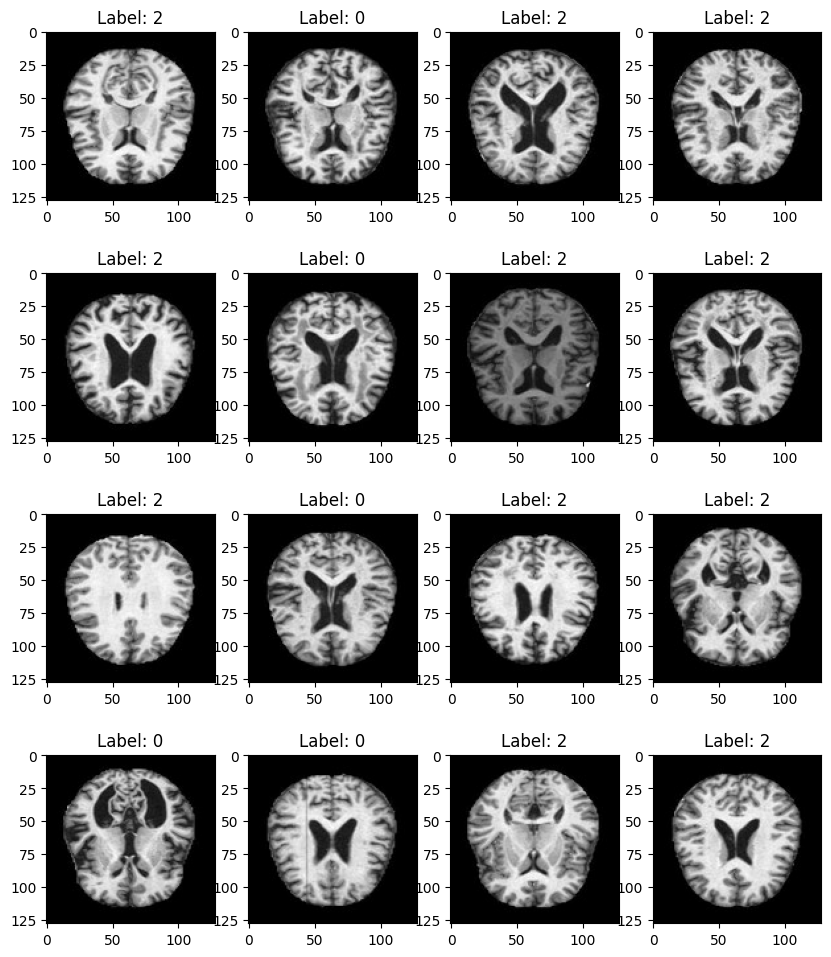

In [71]:
import matplotlib.pyplot as plt

# img_data에서 이미지 데이터와 라벨 데이터를 묶어서 tuple 형태로 반환
img_data = data.skip(int(len(data)*0.1))

# tuple을 ndarray로 변환
img_data = np.array(list(img_data))

# train_data에서 16개 이미지 추출
image_batch = next(iter(img_data))[0][:16]
image_label = next(iter(img_data))[1][:16]
# 추출한 이미지 시각화
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 12))
for i, ax in enumerate(axes.flat):
    # 이미지 출력
    ax.imshow(image_batch[i].numpy().astype('uint8'))

    # 라벨 출력
    label = image_label[i]
    ax.set_title(f"Label: {label}")

plt.show()

# 모델 학습

## CNN

In [72]:
model_cnn = keras.models.Sequential()
model_cnn.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model_cnn.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model_cnn.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model_cnn.add(keras.layers.Dropout(0.10))

model_cnn.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model_cnn.add(keras.layers.Dropout(0.1))

model_cnn.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model_cnn.add(keras.layers.Dropout(0.1))
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal"))
model_cnn.add(keras.layers.Dropout(0.05))
model_cnn.add(keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"))
model_cnn.add(keras.layers.Dense(3, activation="softmax"))

#, kernel_regularizer=keras.regularizers.l2(0.001)

In [73]:
model_cnn.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"], 
                )

In [74]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 32)       

In [75]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [1]:
hist_cnn = model_cnn.fit(train_data,validation_data=val_data,
                         epochs=100, batch_size=64,
                          callbacks = early_stop, verbose=1)

NameError: name 'model_cnn' is not defined

# 학습 결과 평가

In [77]:
df_cnn = pd.DataFrame(hist_cnn.history)
df_cnn

,loss,accuracy,val_loss,val_accuracy
0,1.225803,0.478477,0.958135,0.513672
1,0.939270,0.523037,0.900620,0.566406
2,0.890597,0.565001,0.911433,0.537109
3,0.838921,0.592256,0.858907,0.609375
4,0.779478,0.630110,0.764971,0.650391
5,0.698740,0.680078,0.588463,0.708984
6,0.602473,0.738482,0.472655,0.791016
7,0.502821,0.787368,0.350865,0.880859
8,0.429792,0.819165,0.266992,0.908203
9,0.358598,0.856154,0.314146,0.861328


<AxesSubplot:>

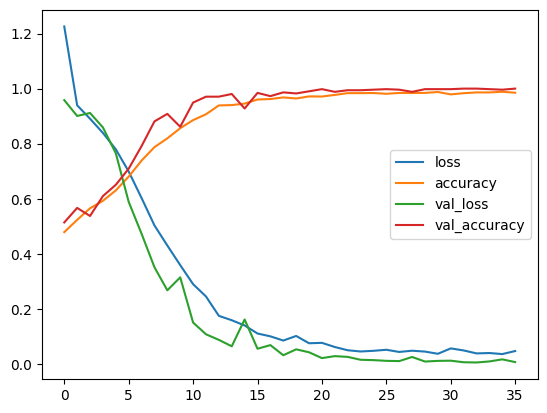

In [80]:
# 그래프로 시각화
df_cnn.plot()

In [150]:

def result_summary(model, X_test, y_test):
    """
    model, X_test, y_test를 입력하면 confusion matrix, classification report를 보여주고
    y_pred_val을 리턴하는 함수
    """
    # X_test에 대한 정답값 예측
    y_pred = model.predict(X_test,batch_size=64, callbacks = early_stop, verbose=0);
    
    # argmax로 클래스 중 정답값 선택
    y_test_val = y_test
    y_pred_val = [np.argmax(y) for y in y_pred]

    # Classification Report
    clr = classification_report(y_test_val, y_pred_val)
    print("Classification Report\n----------------------\n", clr)

    # Confusion Matrix
    cm = confusion_matrix(y_test_val, y_pred_val)
    print("\n\nConfusion Matrix\n----------------------")
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual");

Classification Report
----------------------
               precision    recall  f1-score   support

           0       0.34      0.34      0.34       441
           1       0.18      0.18      0.18       193
           2       0.51      0.51      0.51       649

    accuracy                           0.40      1283
   macro avg       0.34      0.34      0.34      1283
weighted avg       0.40      0.40      0.40      1283



Confusion Matrix
----------------------


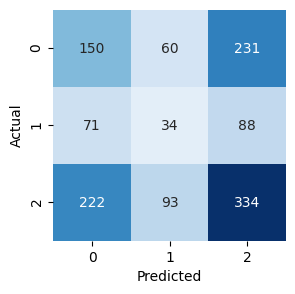

In [151]:
result_summary(model_cnn, test_data, test_labels)

# Prediction

In [140]:
loss, accuracy = model_cnn.evaluate(test_data, batch_size=64, callbacks = early_stop)

21/21 [==============================] - 0s 12ms/step - loss: 0.0428 - accuracy: 0.9860


In [142]:
# 이미지 불러와서 확인
def load_pred_img(model, test_data):
    plt.figure(figsize=(20, 20))
    for images, labels in test_data.take(1):
        predictions = model.predict(images, batch_size=64, callbacks = early_stop)
        for i in range(16):
            ax = plt.subplot(4, 4, i + 1)
            predicted_label = np.argmax(predictions[i])
            if predicted_label == labels[i]:
                plt.imshow(images[i].numpy().astype("uint8"), cmap="Greens")
                plt.title("Actual: "+labels[i])
                plt.ylabel("Predicted: "+predicted_label, fontdict={'color':'green'})
            else:
                plt.imshow(images[i].numpy().astype("uint8"), cmap="Reds")
                plt.title("Actual: "+labels[i])
                plt.ylabel("Predicted: "+predicted_label, fontdict={'color':'red'})
            plt.gca().axes.yaxis.set_ticklabels([])        
            plt.gca().axes.xaxis.set_ticklabels([])


1/1 [==============================] - 0s 25ms/step


TypeError: Cannot convert 'Actual: ' to EagerTensor of dtype int32

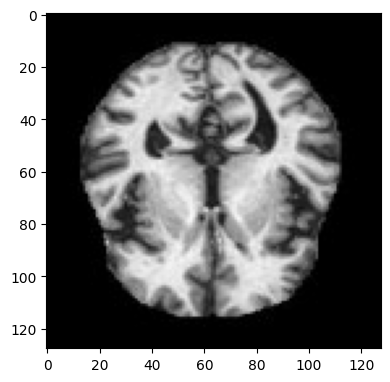

In [143]:
load_pred_img(model_cnn, test_data)

In [ ]:
# 지민님 cnn 모델

In [131]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

# CNN 모델 생성
cnn=Sequential()

#initially 64 convolution nodes
cnn.add(Conv2D(64,(3,3),padding="same",activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
#add a Max Pooling layer
cnn.add(MaxPooling2D())

#another 32 convolution nodes
cnn.add(Conv2D(32,(3,3),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())

#Add 32 convolutions
cnn.add(Conv2D(32,(2,2),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())

#Flatten before adding fully connected layer
cnn.add(Flatten())

#Add a hidden layer with 100 nodes
cnn.add(Dense(100,activation='relu'))

#Add another hidden layer with 50 nodes
cnn.add(Dense(50,activation='relu'))

# Add final ouptput layer : 클래스의 개수대로 만들어줌 (다중분류 softmax)
cnn.add(Dense(3, activation='softmax'))

In [132]:
cnn.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"], 
                )

In [133]:
cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)      

In [134]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [135]:
hist_cnn_jesus = cnn.fit(train_data,validation_data=val_data,
                         epochs=100, batch_size=64,
                          callbacks = early_stop, verbose=1)

Epoch 1/100
73/73 [==============================] - 2s 22ms/step - loss: 2.5398 - accuracy: 0.4884 - val_loss: 0.8421 - val_accuracy: 0.5742
Epoch 2/100
73/73 [==============================] - 2s 21ms/step - loss: 0.8514 - accuracy: 0.5786 - val_loss: 0.8975 - val_accuracy: 0.5879
Epoch 3/100
73/73 [==============================] - 2s 21ms/step - loss: 0.7613 - accuracy: 0.6483 - val_loss: 0.7788 - val_accuracy: 0.6250
Epoch 4/100
73/73 [==============================] - 2s 20ms/step - loss: 0.6772 - accuracy: 0.6967 - val_loss: 0.6342 - val_accuracy: 0.7441
Epoch 5/100
73/73 [==============================] - 2s 20ms/step - loss: 0.6048 - accuracy: 0.7350 - val_loss: 0.5928 - val_accuracy: 0.7383
Epoch 6/100
73/73 [==============================] - 2s 20ms/step - loss: 0.5365 - accuracy: 0.7748 - val_loss: 0.6264 - val_accuracy: 0.7285
Epoch 7/100
73/73 [==============================] - 2s 20ms/step - loss: 0.4483 - accuracy: 0.8161 - val_loss: 0.4745 - val_accuracy: 0.8203
Epoch 

# 학습 결과 평가

In [136]:
df_cnn_jesus = pd.DataFrame(hist_cnn_jesus.history)
df_cnn_jesus

,loss,accuracy,val_loss,val_accuracy
0,2.539813,0.488427,0.842094,0.574219
1,0.851362,0.578629,0.897469,0.587891
2,0.761310,0.648280,0.778825,0.625000
3,0.677211,0.696734,0.634153,0.744141
4,0.604787,0.735021,0.592762,0.738281
5,0.536469,0.774822,0.626354,0.728516
6,0.448325,0.816137,0.474501,0.820312
7,0.428025,0.817435,0.452698,0.802734
8,0.365990,0.851611,0.453557,0.792969
9,0.305864,0.882544,0.365934,0.853516


<AxesSubplot:>

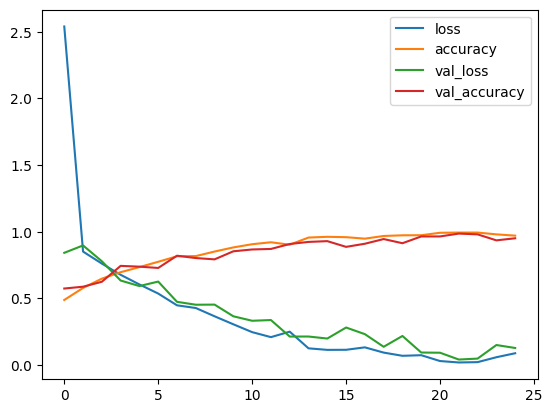

In [137]:
# 그래프로 시각화
df_cnn_jesus.plot()

In [139]:
cnn.evaluate(test_data, test_labels,batch_size=64,callbacks=early_stop, )

ValueError: `y` argument is not supported when using dataset as input.

Classification Report
----------------------
               precision    recall  f1-score   support

           0       0.35      0.35      0.35       441
           1       0.15      0.11      0.13       193
           2       0.51      0.55      0.53       649

    accuracy                           0.42      1283
   macro avg       0.34      0.34      0.34      1283
weighted avg       0.40      0.42      0.41      1283



Confusion Matrix
----------------------


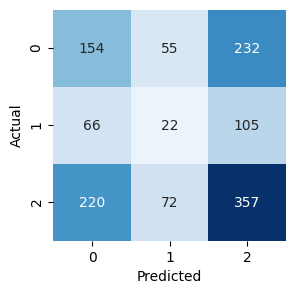

In [138]:
result_summary(cnn, test_data, test_labels)

## ResNet50

In [119]:
# tensorflow.keras.applications.resnet50 에서 ResNet50 을 불러옵니다.
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import regularizers

IMG_HEIGHT = 128
IMG_WIDTH = 128
res = ResNet50(
    include_top=False,
    weights=None,
    input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
    pooling='avg',
    classes =3,
)
model_res = Sequential()
model_res.add(res)
model_res.add(Flatten())
model_res.add(Dropout(0.5))
model_res.add(Dense(units=64, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model_res.add(Dense(units=3, activation="softmax"))


In [120]:
# summary
model_res.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                131136    
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 23,719,043
Trainable params: 23,665,923
Non-trainable params: 53,120
_________________________________________________________________


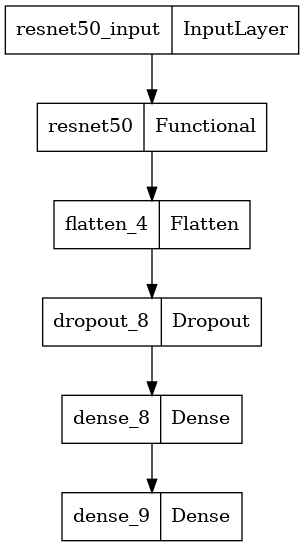

In [121]:
# tensorflow.keras.utils의 plot_model 을 통한 레이어 시각화
from tensorflow.keras.utils import plot_model

plot_model(model_res)

In [122]:
model_res.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [123]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [124]:
hist_res = model_res.fit(train_data,validation_data=val_data,epochs=100, 
                         batch_size=64, callbacks = early_stop,
                         verbose=1)

Epoch 1/100
73/73 [==============================] - 11s 90ms/step - loss: 2.0857 - accuracy: 0.5075 - val_loss: 1.8670 - val_accuracy: 0.3984
Epoch 2/100
73/73 [==============================] - 6s 78ms/step - loss: 1.4860 - accuracy: 0.5741 - val_loss: 1.4702 - val_accuracy: 0.5391
Epoch 3/100
73/73 [==============================] - 6s 78ms/step - loss: 1.1416 - accuracy: 0.6401 - val_loss: 2.5174 - val_accuracy: 0.5449
Epoch 4/100
73/73 [==============================] - 6s 78ms/step - loss: 0.8863 - accuracy: 0.7041 - val_loss: 2.9005 - val_accuracy: 0.3105


In [125]:
df_res = pd.DataFrame(hist_res.history)
df_res


,loss,accuracy,val_loss,val_accuracy
0,2.085713,0.507463,1.867033,0.398438
1,1.486026,0.574086,1.470240,0.539062
2,1.141574,0.640061,2.517410,0.544922
3,0.886271,0.704088,2.900469,0.310547


## VGG

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
from sklearn.utils import class_weight
classes = np.unique(train_set.classes)
weights_balance = class_weight.compute_class_weight(class_weight='balanced', classes=classes,y=train_set.classes)
class_weights = dict(zip(classes, weights_balance))
print(class_weights)

In [ ]:
def callbacks():
    checkpoint = ModelCheckpoint('best_vgg16.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

    return checkpoint, early

call_callbacks = callbacks()